In [1]:
import cv2
import numpy as np
import imutils
import random
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans

# Лабораторная работа №15 (№9 в учебнике)

# 9.1 Обзор функций, которые используются в проекте

# Обзор функции get_color()
Рассмотрим функцию get_color(), которая принимает изображение в формате HSV. В ней инициализируется объект KMeans. Затем метод fit вызывается на объекте KMeans и передается массив pixels для обучения алгоритма кластеризации. После обучения KMeans, функция получает координаты центра кластера с наибольшим количеством пикселей, используя kmeans.cluster_centers[0] Полученный главный цвет представлен в виде массива координат RGB и преобразуется в список с помощью list(). Наконец, функция возвращает доминирующий цвет.

In [2]:
def get_color(image):
    pixels = np.float32(image.reshape(-1, 3))
    n_colors = 1
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    dominant_color = list(kmeans.cluster_centers_[0])

    return dominant_color

# Обзор функции shelf()

Функция def shelf () предназначена для удаления фона. В процессе работы этой программы сканируется все строки, начиная с верхней. Если при сканировании интенсивности пикселей не меняются, то они обнуляются. В результате на изображении фон становится темным.

In [3]:
def shelf (img, k = 120):
    x = 0
    
    for i in range (img.shape[1]):
        if x > ((img.shape[1])/1.01):
            img[i-1] = [0, 0, 0]
            img[i-2] = [0, 0, 0]
            x = 0
        for j in range(img.shape[0]):
            if(img[i][0][0] - k <= img[i][j][0] <=
            img[i][0][0] + k) and (
                img[i][0][1] - k <= img[i][j][1] <=
                img[i][0][1] + k
            ) and (
                img[i][0][2] - k <= img[i][j][2] <=
                img[i][0][2] + k
            ):
                x += 1
    
    return img.astype(np.uint8)

Продемонстрируем работу функции shelf():

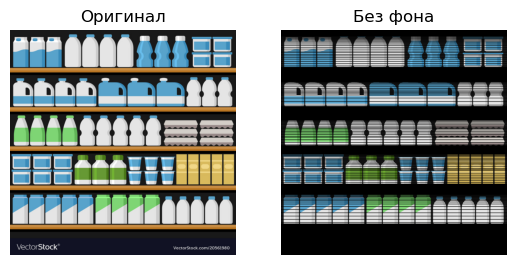

In [4]:
img = cv2.imread("supermarket.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (900, 900))

res = np.copy(img)
res = shelf(res, k=40)

plt.subplot(121), plt.imshow(img), plt.title('Оригинал')
plt.axis('off')
plt.subplot(122), plt.imshow(res), plt.title('Без фона')
plt.axis('off')
plt.show()

Так как эта функция сканирует строки, и обнуляет те, в которых значение интенсивности пикселей не меняются, её работа неточна и подойдёт для малого количества изображений.

# Обзор функции background() 

In [5]:
def background(imr, p = 40):
    hsv_image = cv2.cvtColor(imr, cv2.COLOR_BGR2HSV)
    dom_color = get_color(hsv_image)
    dom_color_hsv = np.full(imr.shape, [255,255,255], dtype='uint8')
    lower = np.array([dom_color[0]-p, dom_color[1]-p, dom_color[2]-p])
    upper = np.array([dom_color[0]+p, dom_color[1]+p, dom_color[2]+p])
    
    mask = cv2.inRange(hsv_image, lower, upper)
    res = cv2.bitwise_not(dom_color_hsv, hsv_image, mask=mask)
    
    return cv2.cvtColor(res, cv2.COLOR_HSV2BGR)

Аргумент p представляет собой параметр для определния диапазона цветов. background() использует определённую раннее функию get_color и сохраняет полученное знчение в переменной dom_color. Затем функция создает верхние и нижние диапазоны цветовых значений. Значения верхнего диапазона увеличиваются на p, а нижнего уменьшаются. Затем создаётся маска по верхним и нижним диапазонам. Затем маска применяется к изображению, в результате получаем изображение без фона. 

Продемонстрируем работу функции:

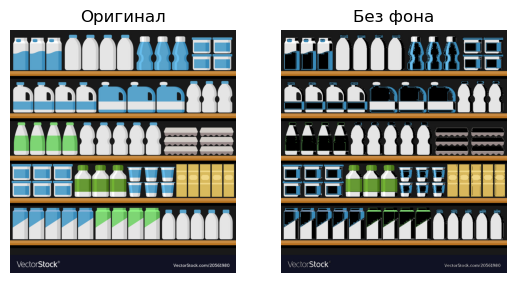

In [6]:
img = cv2.imread('supermarket.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imr = background(img, p=75)

plt.subplot(121), plt.imshow(img), plt.title('Оригинал')
plt.axis('off')
plt.subplot(122), plt.imshow(imr), plt.title('Без фона')
plt.axis('off')
plt.show()

# Обзор функции segment()
Функция segment() предназначена для разбиения всего поля изображения на сегменты, с последующей их маркировкой. Используя функцию cv2.threshold, получим, задавая порог 100, бинарное изображение. Затем создадим ядро и воспользуемся морфологической функцией cv2.morphologyEx() в режиме открытия. Операция открытия – это последовательность двух операций: сначала
применяется операция эрозии, потом операция расширения. Операция открытия хорошо удаляет шум с изображения. Затем полученное изображение обрабатывается операцией закрытия. 

In [7]:
def segment (img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    im_bw = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]
    kernel = np.ones((3,3) , np.uint8)
    opening = cv2.morphologyEx(
        im_bw, cv2.MORPH_OPEN, kernel, iterations = 1
    )
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
    ret, sure_fg = cv2.threshold(
        dist_transform, 0.01*dist_transform.max(), 255, 0
    )
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.Canny(sure_bg, 200, 200, apertureSize=3)
    ret, mark = cv2.connectedComponents(sure_fg)
    mark += 1
    mark[unknown == 255] = 0
    markers = cv2.watershed(img, mark)
    img[markers == -1] = [255, 0, 0]
    
    return img, im_bw, unknown

После бинаризации изображения и очистки его от шума увеличиевается расстояние между объектами. Для этого применяется distanceTransform, а затем к полученному изображению применяется пороговая обработка. Выделим контуры методом Кенни, а затем присовим каждой области внутри контура некоторый символ. Это и называется операцией маркировки. Сегментация изображения проводится методом водораздела cv2.watershed()

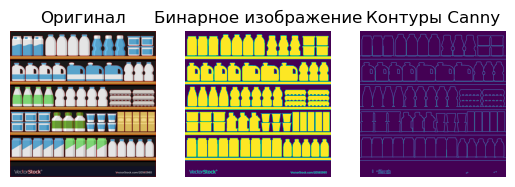

In [8]:
img = cv2.imread('supermarket.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (900, 900))

img, im_bw, canny = segment(img)

plt.subplot(131), plt.imshow(img), plt.title('Оригинал')
plt.axis('off')
plt.subplot(132), plt.imshow(im_bw), plt.title('Бинарное изображение')
plt.axis('off')
plt.subplot(133), plt.imshow(canny), plt.title('Контуры Canny')
plt.axis('off')
plt.show()

# 9.2 Распознование объекта по шаблону
Метод заключается в поиске объекта на большом изображении, который соответсвует выбранному шаблону. Поиск проводится с помощью функции cv2.matchTemplate(). Шаблон перемещается по изображению и его пиксели сравниваются с градациями серого.

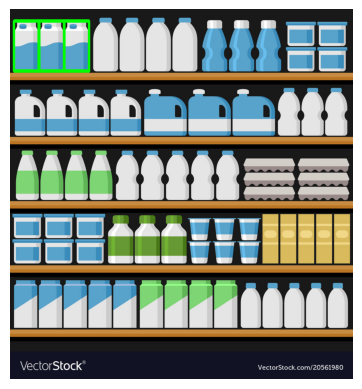

In [9]:
img_rgb = cv2.imread('supermarket.jpg')
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
template = cv2.imread('milk.jpg', 0)
w, h = template.shape[::-1]
res = cv2.matchTemplate(
    img_gray, 
    template, 
    cv2.TM_CCOEFF_NORMED
)
threshold = 0.8
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(
        img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2
    )
    
cv2.imwrite('res.png', img_rgb)

plt.axis('off')
plt.imshow(img_rgb);  

Для правильного создания признаков объектов их нужно привести к одинаковому размеру по высоте. Для этого у каждого объекта определяем коэффициент пересчета k = h1/h0, где h0 – стандартная высота, в нашем случае h0 = 160, h1 – старая высота. Тогда новая ширина равна w = w1* h1/h0.

In [10]:
image = cv2.imread('milk.jpg', 1)
s = image.shape 
h1, w1 = s[0], s[1] 
wr = round(77 * h1 / 160)
img = cv2.resize(image, (wr, 160))
cv2.imwrite("r1.jpg", img)
print(s)
print(w1)

(146, 72, 3)
72


# 9.3 Составление таблицы признаков
Для создания таблицы признаков объекта цветное изображение
трансформируется в серое. Затем на основе массива точек изображения и массива координат кон-
тура вычисляются все признаки объекта.

0 0 4 18
32.0
46.97056245803833
4 18
0.2222222222222222 0.4444444444444444
6.383076486422923
{'m00': 32.0, 'm10': 40.33333333333333, 'm01': 269.8333333333333, 'm20': 68.66666666666666, 'm11': 312.66666666666663, 'm02': 2788.1666666666665, 'm30': 135.1, 'm21': 492.1166666666667, 'm12': 3027.616666666667, 'm03': 32500.850000000002, 'mu20': 17.829861111111114, 'mu11': -27.435763888888857, 'mu02': 512.8532986111113, 'mu30': 3.605280671296299, 'mu21': -17.739706307870335, 'mu12': -23.94234302662005, 'mu03': 341.1582591869228, 'nu20': 0.017411973741319448, 'nu11': -0.026792738172743025, 'nu02': 0.5008332994249134, 'nu30': 0.0006223921901255863, 'nu21': -0.0030624674381232635, 'nu12': -0.0041332502713909884, 'nu03': 0.05889534143771263}


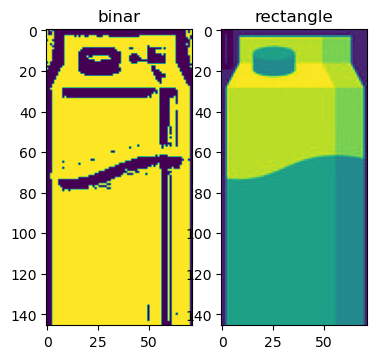

In [11]:
img = cv2. imread('milk.jpg', 0)
th = cv2.adaptiveThreshold(
    img, 255, 
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY,
    11,2
)
contours, hierarchy = cv2.findContours(th, 5, 5)
plt.subplot(131), plt.imshow(th), plt.title('binar')

cnt = contours[0]
area = cv2.contourArea(cnt)
prm = cv2.arcLength(cnt, True)
hull = cv2.convexHull(cnt)
x, y, w, h = cv2.boundingRect(cnt)
print(x, y, w, h)
imag = cv2.rectangle(
    img, 
    (x, y),
    (x+w,y+h),
    (0,255,0), 
    2
)
plt.subplot(132), plt.imshow(imag), plt.title('rectangle')
x, y, w, h = cv2.boundingRect(cnt)
epsilon = 0.1 * cv2.arcLength(cnt, True)
aspect_ratio = float(w) / h
rect_area = w * h
extent = float(area) / rect_area
hull_area = cv2.contourArea(hull)
equi_diameter = np.sqrt(4 * area / np.pi)
mask = np.zeros(img.shape, np.uint8)
cv2.drawContours(mask, [cnt], 0, 255, -1)
M = cv2.moments(cnt)
x, y, w, h = cv2.boundingRect(cnt)
pixelpoints = np.transpose(np.nonzero(mask))
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img, mask=mask)
leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])
print(area)
print(prm)
print(w,h)
print(aspect_ratio, extent)
print(equi_diameter)
print(M)

# 9.4 Распознование объектов с помощью нейронной сети

In [12]:
s = [284.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
p = [157.55, 141.34, 90.476, 1262.1, 61.799, 78.064, 175.47, 48.730]
w = [31, 51, 7, 66, 15, 5, 24, 5]
h = [54, 26, 41, 158, 22, 37, 70, 22]
kw = [0.574, 1.9615, 0.1707, 0.4177, 0.6818, 0.1351, 0.3429, 0.2272]
ks = [0.7461, 0.4351, 0.6289, 0.7475, 0.4939, 0.6, 0.5414, 0.2682]
d = [39.878, 27.105, 15.160, 99.627, 14.406, 11.888, 34.029, 6.1287]
m0 = [284.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
m1 = [15994, 18479, 3319.8, 255475, 790.83, 174.5, 8059.0, 40.833]
m2 = [27883, 4990.2, 1440.7, 616222, 1220.3, 2033.3, 21165, 160.5]
m3 = [307788, 175877, 180.5, 19613900, 4657.8, 3300.2, 153434, 152.375]
weights = [0.3, 0.5, 0.1, 0.2, 1, 1, 1, 1, 1, 1, 1]

def sum(a, b):
    assert(len(a) == len(b))
    output = 0
    for i in range(len(a)):
        output += (a[i] * b[i])
    return output

def art_neuron(input, weights):
    pred = sum(input, weights)
    return pred

in0 = [s[0], p[0], w[0], h[0], kw[0], ks[0], d[0], m0[0], m1[0], m2[0], m3[0]]
in1 = [s[1], p[1], w[1], h[1], kw[1], ks[1], d[1], m0[1], m1[1], m2[1], m3[1]]
in2 = [s[2], p[2], w[2], h[2], kw[2], ks[2], d[2], m0[2], m1[2], m2[2], m3[2]]
in3 = [s[3], p[3], w[3], h[3], kw[3], ks[3], d[3], m0[3], m1[3], m2[3], m3[3]]
in4 = [s[4], p[4], w[4], h[4], kw[4], ks[4], d[4], m0[4], m1[4], m2[4], m3[4]]
in5 = [s[5], p[5], w[5], h[5], kw[5], ks[5], d[5], m0[5], m1[5], m2[5], m3[5]]

print(in0)
print(in5)

pred0 = art_neuron(in0, weights)
pred1 = art_neuron(in1, weights)
pred2 = art_neuron(in2, weights)
pred3 = art_neuron(in3, weights)
pred4 = art_neuron(in4, weights)
pred5 = art_neuron(in5, weights)

print(pred0)
print(pred1)
print(pred2)
print(pred3)
print(pred4)
print(pred5)


[284.0, 157.55, 31, 54, 0.574, 0.7461, 39.878, 284.0, 15994, 27883, 307788]
[111.0, 78.064, 5, 37, 0.1351, 0.6, 11.888, 111.0, 174.5, 2033.3, 3300.2]
352168.0731
200206.7716
5245.747600000001
20496501.1922
6933.2112
5711.8551
